# Aim

This notebook contains code to assess the performance of a pre-trained model on **new data**.

### Imports
Import libraries and write settings here.

In [1]:
# OS related
import os
import sys
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:,.4f}'.format

# autoreload extension
%load_ext autoreload
%autoreload 2

# add repo root path to pythonpath
### Note: this assumes custom python modules are accessible in the root path AND notebooks are in a folder inside root, e.g. root/notebooks
sys.path.insert(0, str(Path.cwd().parent))

# Experiment configuration

The following cell collects all the hyperparameters needed for the experiment.

<div class="alert alert-block alert-info">
    
In this notebook we focus on **red** data, and we consider the model resulting from the experiment named as `red_98765`.
    
**Feel free to edit `EXP_NAME` variable to load other available weights.**
</div>

In [2]:
from fastai.vision.all import *
from fluocells.config import REPO_PATH, DATA_PATH, DATA_PATH_g, DATA_PATH_y, DATA_PATH_r, METADATA, MODELS_PATH


BS = 1
DATASET = "S-BSST265"
SEED = 47
VAL_PCT = 0
dataset_path = REPO_PATH / "public_datasets" / DATASET / "dataset"

set_seed(SEED)

# model params
N_IN, N_OUT = 16, 2
PRETRAINED = True

# optimizer params
LOSS_FUNC, LOSS_NAME = DiceLoss(axis=1, smooth=1e-06, reduction='mean', square_in_union=False), 'Dice'

# EXP_NAME = "yellow_47_Combined_weights=(0.5, 0.2, 0.5)"
# EXP_NAME = "yellow_5_FT_default"
EXP_NAME = "yellow_0_Dice"
log_path = REPO_PATH / "logs" / EXP_NAME
model_path = MODELS_PATH / EXP_NAME
results_path = REPO_PATH / "results" / EXP_NAME
results_path.mkdir(exist_ok=True, parents=True)

##  Dataloaders

For simplicity we load data on the cpu.

### Training


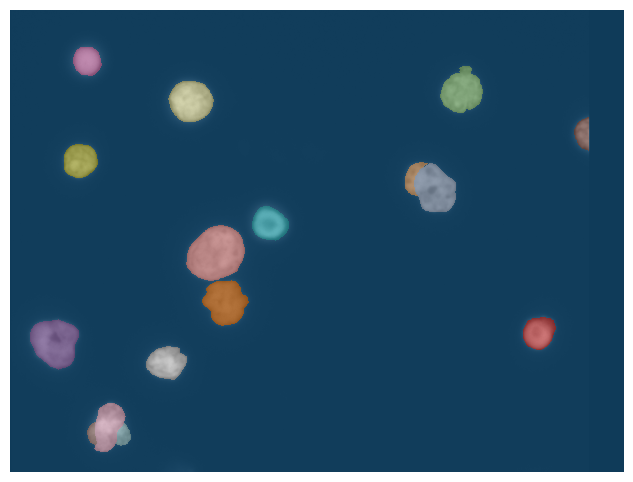

In [3]:
DEVICE = "cpu"
def label_func(p):
    return Path(str(p).replace("rawimages", "groundtruth"))


trainval_path = dataset_path / "rawimages" # edit dataset folder here: DATA_PATH_g --> green; DATA_PATH_y --> yellow; DATA_PATH_r --> red 

# read train/valid/test split dataframe
trainval_fnames = [fn for fn in trainval_path.iterdir()]

# augmentation
tfms = [
    # IntToFloatTensor(div_mask=255.),  # need masks in [0, 1] format
    Resize((1024, 1360), method=ResizeMethod.Pad, pad_mode="zeros")
]

# splitter
splitter = RandomSplitter(valid_pct=VAL_PCT)

# dataloader
dls = SegmentationDataLoaders.from_label_func(
    DATA_PATH, fnames=trainval_fnames, label_func=label_func,
    bs=BS,
    splitter=splitter,
    item_tfms=tfms,
    device=DEVICE 
)

dls.show_batch(max_n=9, figsize=(8,6))

In [4]:
for i, b in enumerate(dls.valid):
    print(b[0].shape)

torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])
torch.Size([1, 3, 1024, 1360])


### Test Dataloader

Note: we use all images as test set

Number of test images: 79


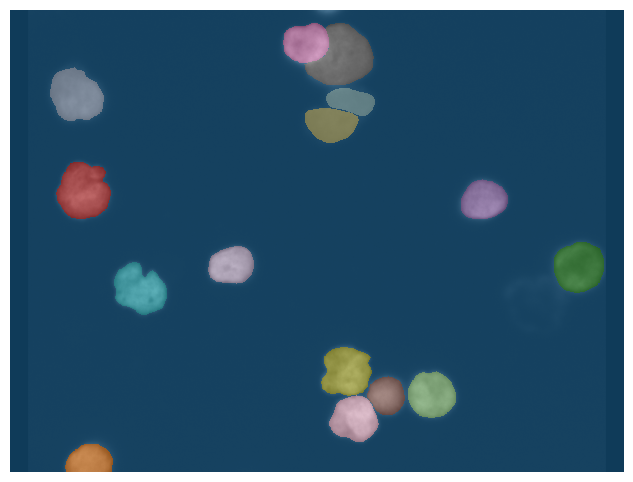

In [5]:
print(f"Number of test images: {len(trainval_fnames)}")
test_dl = dls.test_dl(trainval_fnames, with_labels=True, tfms=tfms, shuffle=False)
test_dl.show_batch(figsize=(8,6))

## Learner

We need to use the same specification as the pre-trained model.

In [6]:
from fluocells.models import cResUnet, c_resunet


torch.set_printoptions(precision=10)

arch = "c-ResUnet"
# pretrained=True would load Morelli et al. 2021 weights. We add new pretrained weights after
cresunet = c_resunet(
    arch=arch, n_features_start=N_IN, n_out=N_OUT, pretrained=True # this would load Morelli et al. 2022
)
# cresunet = cResUnet(cfg.n_in, cfg.n_out)

learn = Learner(dls, model=cresunet, loss_func=LOSS_FUNC,
                metrics=[Dice(), JaccardCoeff(), foreground_acc],
                path=log_path , 
                model_dir=model_path,
                )  

print(
    f'Logs save path: {learn.path}\nModel save path: {learn.path / learn.model_dir}')

learn.summary()

loading pretrained Keras weights from /home/luca/workspace/luca/PycharmProjects/fluocells-BVPAI/models/c-ResUnet_state_dict.pkl
Logs save path: /home/luca/workspace/luca/PycharmProjects/fluocells-BVPAI/logs/yellow_0_Dice
Model save path: /home/luca/workspace/luca/PycharmProjects/fluocells-BVPAI/models/yellow_0_Dice


cResUnet (Input shape: 1 x 3 x 1024 x 1360)
Layer (type)         Output Shape         Param #    Trainable 
                     1 x 1 x 1024 x 1360 
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     1 x 16 x 1024 x 136 
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     1 x 16 x 512 x 680  
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                 

## Load model

We load one of the pre-trained models obtained from sample trainings.

In [7]:
print(f"Loading pesi da: {model_path}")

learn.load(model_path / 'model') # model.pth

Loading pesi da: /home/luca/workspace/luca/PycharmProjects/fluocells-BVPAI/models/yellow_0_Dice


In [8]:
learn.eval()

cResUnet(
  (encoder): ModuleDict(
    (colorspace): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
    (conv_block): ConvBlock(
      (conv_block): ModuleDict(
        (batchnorm2d_0): BatchNorm2d(1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (activation_1): ELU(alpha=1.0)
        (conv2d_2): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm2d_3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (activation_4): ELU(alpha=1.0)
        (conv2d_5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (residual_block1): ResidualBlock(
      (conv_path): ConvBlock(
        (conv_block): ModuleDict(
          (batchnorm2d_0): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (activation_1): ELU(alpha=1.0)
          (conv2d_2): Con

# Visual inspection

## Utils

Let's first define some utils to plot images, masks and predictions.

In [9]:
from skimage import measure
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable


def _get_dataloader_batch(idx, dl=test_dl):
    for i, batch in enumerate(dl, start=1):
        if i==idx: break       
    return batch


def multiclass_to_binary_mask(mask):
    binary_mask = mask
    binary_mask[binary_mask>0] = 255
    return binary_mask


def plot_heatmap(heatmap, ax):
    im = ax.imshow(heatmap, cmap='jet')  
    divider = make_axes_locatable(ax)
    cbar_ax = divider.append_axes("right", size="5%", pad=0.05)

    # get colorbar to set params
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    return im


def plot_mask(mask: np.array, axis = None):
    """Plot mask with a different color per object and title."""
    nobjs = len(np.unique(mask))
    if nobjs<3:
        labels, nobjs = measure.label(mask, return_num=True, connectivity=1)
    else:
        labels = mask
    objs = measure.regionprops(labels)
    
    # create colormap: one color per object
    cmap = cm.get_cmap('tab20b', nobjs)

    # random shuffle to avoid similar colors to close-by objects
    np.random.shuffle(cmap.colors)

    # add black for background
    cmap = ListedColormap(np.insert(cmap.colors, 0, [0, 0, 0, 1], axis=0))

    # plot mask
    if axis is None:
        fig, axis = plt.subplots(1, 1, figsize=(8, 8))
    else: 
        fig = axis.figure
    axis.imshow(labels, cmap=cmap, vmin=0, vmax=nobjs)
    for obj in objs:
        plt.text(obj.bbox[1], obj.bbox[0], obj.label,
                 fontdict=dict(color='white', size=7),
                 bbox=dict(fill=False, linewidth=0)
                 )

    return fig, axis, cmap

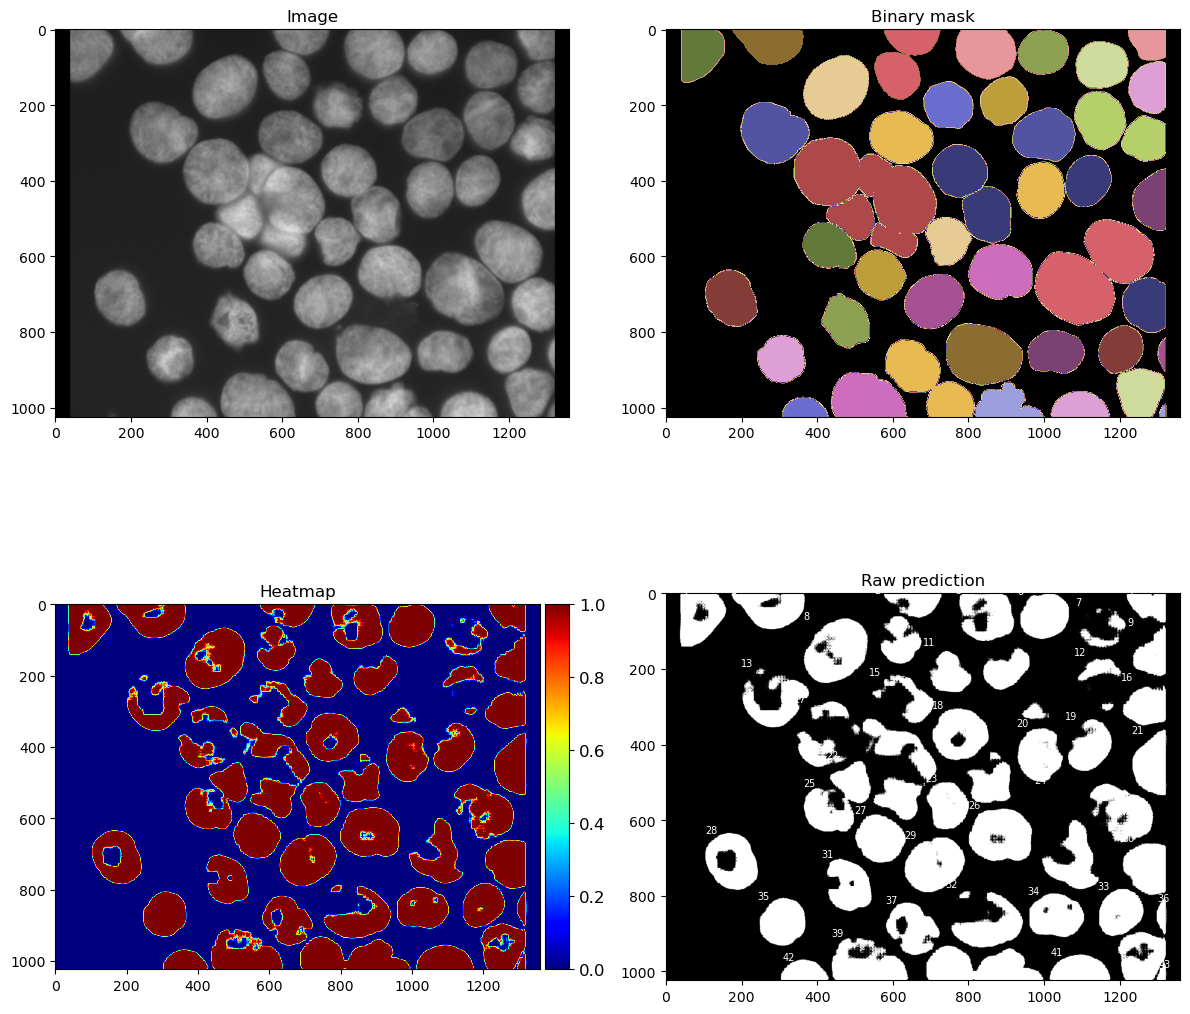

In [10]:
# test dataloader
batch_id = 4
img, mask = _get_dataloader_batch(batch_id, test_dl)
heatmap = learn.model(img)

# convert to matplotlib format
C=1
img = img.squeeze().permute(1,2,0).to("cpu")
mask = mask.squeeze().to("cpu")
binary_mask = multiclass_to_binary_mask(mask)

heatmap_plot = heatmap.squeeze().permute(1,2,0)[:,:,C].detach().to("cpu")
pred_mask = heatmap.squeeze().permute(1,2,0).argmax(dim=2).squeeze().type(torch.uint8).to("cpu")

fig, axes = plt.subplots(2,2, figsize=(12, 12))
axes = axes.flatten()
axes[0].imshow(img)
axes[0].set_title('Image')
# axes[1].imshow(mask, cmap='gray')
plot_mask(mask, axes[1])
axes[1].set_title('Binary mask')
plot_heatmap(heatmap_plot, axes[2])
axes[2].set_title('Heatmap')
axes[3].imshow(pred_mask, cmap='gray')
axes[3].set_title('Raw prediction')
plt.tight_layout()
plt.show()

## Post-processing

First let's get some statistics about the cell dimensions and diameters of the new dataset. 

In [54]:
# first let's get some insights on target object dimensions 
from skimage import io
from tqdm.auto import tqdm
from skimage.morphology import remove_small_holes, remove_small_objects
from fluocells.utils.data import _compute_masks_stats, _enrich_stats


def clean_mask(
    mask: np.ndarray, max_hole_size: int, min_object_size: int
):
    # fill holes
    mask = remove_small_holes(
        mask.astype(bool), area_threshold=max_hole_size
    )  # return array [False, True]
    mask = remove_small_objects(mask.astype(bool), min_size=min_object_size)
    return (mask * 255).astype("uint8")


def compute_masks_stats(
    masks_paths: List[Path], outpath: Union[None, Path] = None
) -> pd.DataFrame:
    """
    Read ground-truth masks and compute metrics for cell counts and shapes
    :param masks_path: masks folder
    :return:
    """
    # paths = [*masks_path.iterdir()]
    stats_df = pd.DataFrame()
    for p in tqdm(masks_paths):
        mask_relative_path = p.relative_to(dataset_path)
        mask = io.imread(p, as_gray=True)
        mask = clean_mask(mask, 36, 5)
        mask_stats = _compute_masks_stats(mask)

        mask_stats = _enrich_stats(mask_stats, mask_relative_path)

        stats_df = pd.concat([stats_df, mask_stats], ignore_index=True)

    if outpath is None:
        outpath = dataset_path / f"{DATASET}_cells_stats_df.csv"
    stats_df.round(4).to_csv(outpath, index=False)
    return stats_df


stats_df = compute_masks_stats([*(dataset_path / "groundtruth").iterdir()])
stats_df.head()

  0%|          | 0/79 [00:00<?, ?it/s]

Shaped series: series shape does not match page shape


,image_name,dataset,partition,n_cells,cell_id,area,min_axis_length,max_axis_length,equivalent_diameter,feret_diameter_max
0,Neuroblastoma_1.tif,groundtruth,Neuroblastoma_1.tif,12.0000,0.0000,"20,810.0000",131.6645,205.0348,162.7763,210.2308
1,Neuroblastoma_1.tif,groundtruth,Neuroblastoma_1.tif,12.0000,1.0000,"10,673.0000",106.8716,128.4187,116.5731,133.0601
2,Neuroblastoma_1.tif,groundtruth,Neuroblastoma_1.tif,12.0000,2.0000,"11,766.0000",99.1970,162.3384,122.3966,163.4136
3,Neuroblastoma_1.tif,groundtruth,Neuroblastoma_1.tif,12.0000,3.0000,"11,704.0000",117.5052,128.2310,122.0737,131.8256
4,Neuroblastoma_1.tif,groundtruth,Neuroblastoma_1.tif,12.0000,4.0000,"7,235.0000",87.3800,105.9886,95.9786,107.9676


In [55]:
stats_df.describe()

,n_cells,cell_id,area,min_axis_length,max_axis_length,equivalent_diameter,feret_diameter_max
count,"5,680.0000","5,680.0000","5,680.0000","5,680.0000","5,680.0000","5,680.0000","5,680.0000"
mean,283.5905,141.2952,"4,554.5210",44.8320,67.8398,52.8039,68.5243
std,254.4168,168.1637,"12,607.7778",47.8538,77.9154,54.8751,76.4645
min,9.0000,0.0000,23.0000,3.0906,7.8960,5.4115,9.2195
25%,62.0000,19.0000,275.0000,16.0912,22.2420,18.7121,23.2594
50%,259.0000,65.5000,614.5000,22.5112,36.1291,27.9715,36.7423
75%,406.0000,216.0000,"3,926.0000",60.7655,88.6161,70.7018,89.6814
max,784.0000,783.0000,"345,228.0000",630.4132,"1,156.7949",662.9917,"1,176.5526"


In [61]:
stats_df["image_type"] = stats_df.image_name.str.split("_").apply(lambda x: x[0])

aggregate_stats = stats_df.groupby("image_type").describe()

average_size = stats_df.equivalent_diameter.mean()
minimum_size = stats_df.area.min()
print("Average cell diameter:", average_size)
print("Minimum cell size:", minimum_size)

# aggregate_stats.xs("equivalent_diameter", level=0, axis=1)
idx = pd.IndexSlice
aggregate_stats.loc[:, idx[['area', "equivalent_diameter"], :]]

Average cell diameter: 52.80387101653422
Minimum cell size: 23.0


area                                              \
                          count        mean         std      min        25%   
image_type                                                                    
Ganglioneuroblastoma 2,152.0000    552.0019    478.3723  29.0000   258.0000   
Neuroblastoma          418.0000 13,091.7679 19,689.5795 531.0000 5,935.7500   
normal               1,956.0000  8,465.2899 17,662.8360  46.0000   293.0000   
otherspecimen        1,154.0000  2,297.4913  5,093.1580  23.0000   206.2500   

                                                         equivalent_diameter  \
                            50%         75%          max               count   
image_type                                                                     
Ganglioneuroblastoma   424.0000    681.0000   6,808.0000          2,152.0000   
Neuroblastoma        8,427.0000 13,082.7500 260,227.0000            418.0000   
normal               3,325.0000 10,210.2500 345,228.0000          1,956.0000   
otherspecimen          674.5000  2,434.7500  66,822.0000          1,154.0000   

                                                                         \
                         mean     std     min     25%      50%      75%   
image_type                                                                
Ganglioneuroblastoma  24.7914  9.3946  6.0765 18.1245  23.2347  29.4462   
Neuroblastoma        115.6672 57.4277 26.0017 86.9346 103.5837 129.0638   
normal                76.9315 69.7307  7.6530 19.3147  65.0655 114.0180   
otherspecimen         41.3761 34.8472  5.4115 16.2051  29.3053  55.6778   

                               
                          max  
image_type                     
Ganglioneuroblastoma  93.1032  
Neuroblastoma        575.6139  
normal               662.9917  
otherspecimen        291.6855

In [66]:
stats_by_image = stats_df.groupby("image_name").describe()
stats_by_image[("area", "min")].describe(percentiles=[0, .10, .25, .50])

count       79.0000
mean     1,613.0506
std      2,842.4036
min         23.0000
0%          23.0000
10%         88.2000
25%        196.0000
50%      1,022.0000
max     23,377.0000
Name: (area, min), dtype: float64

In [75]:
stats_by_image = stats_df.groupby("image_name").describe()
stats_by_image[("equivalent_diameter", "min")].describe(percentiles=[0, .10, .25, .50])

count    79.0000
mean     37.2871
std      25.9225
min       5.4115
0%        5.4115
10%      10.5967
25%      15.7700
50%      36.0729
max     172.5240
Name: (equivalent_diameter, min), dtype: float64

In [67]:
to_check = stats_df[stats_df.area <100]
to_check

,image_name,dataset,partition,n_cells,cell_id,area,min_axis_length,max_axis_length,equivalent_diameter,feret_diameter_max,image_type
271,Ganglioneuroblastoma_4.tif,groundtruth,Ganglioneuroblastoma_4.tif,306.0000,30.0000,69.0000,8.4712,10.4423,9.3730,11.7047,Ganglioneuroblastoma
281,Ganglioneuroblastoma_4.tif,groundtruth,Ganglioneuroblastoma_4.tif,306.0000,40.0000,81.0000,6.7347,15.4978,10.1554,16.4924,Ganglioneuroblastoma
297,Ganglioneuroblastoma_4.tif,groundtruth,Ganglioneuroblastoma_4.tif,306.0000,56.0000,69.0000,6.7293,13.1577,9.3730,13.6015,Ganglioneuroblastoma
306,Ganglioneuroblastoma_4.tif,groundtruth,Ganglioneuroblastoma_4.tif,306.0000,65.0000,88.0000,7.4559,15.2728,10.5851,15.2643,Ganglioneuroblastoma
331,Ganglioneuroblastoma_4.tif,groundtruth,Ganglioneuroblastoma_4.tif,306.0000,90.0000,94.0000,8.3082,14.5307,10.9400,14.5602,Ganglioneuroblastoma
...,...,...,...,...,...,...,...,...,...,...,...
4776,normal_34.tif,groundtruth,normal_34.tif,784.0000,756.0000,58.0000,6.9249,11.2690,8.5935,12.1655,normal
4801,normal_34.tif,groundtruth,normal_34.tif,784.0000,781.0000,96.0000,7.4311,17.0277,11.0558,17.1172,normal
4802,normal_34.tif,groundtruth,normal_34.tif,784.0000,782.0000,48.0000,5.5710,11.2194,7.8176,11.1803,normal
4803,normal_34.tif,groundtruth,normal_34.tif,784.0000,783.0000,46.0000,5.0329,11.9855,7.6530,12.0416,normal


<div class="alert alert-block alert-info">

Cells have typically different sizes depending on the image type. 

This affects post-processing (`max_hole`, `min_size`) and evaluation (`prox_thresh` should be set depending on the average cell size per type).
For simplicity, we use global values retrieved from insights drawn from the above table ([36, ])
<div/>

### Predictions

/home/luca/miniconda3/envs/fluocells/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/home/luca/workspace/luca/PycharmProjects/fluocells-BVPAI/fluocells/utils/data.py:519: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(


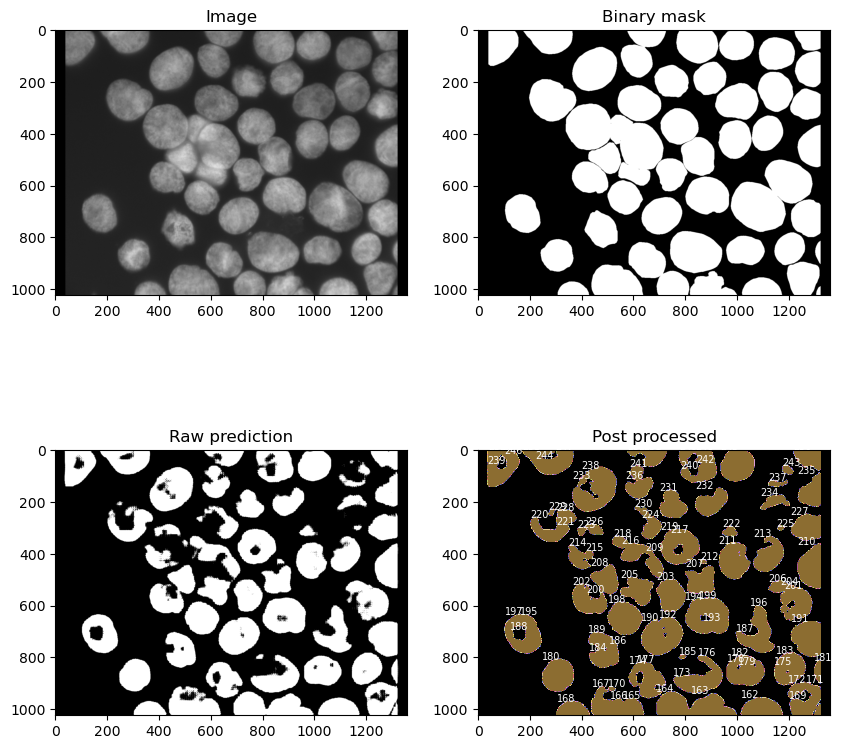

In [11]:
from fluocells.utils.data import post_process


threshold = 0.875
smooth_disk = 3
max_hole = 50
min_size = 200
max_dist = 30
fp = 40
iou_thresh = 0.4
prox_thresh = 40

thresh_image = np.squeeze((heatmap_plot.numpy() > threshold).astype('uint8'))
post_proc_mask = post_process(thresh_image, smooth_disk, max_hole, min_size, max_dist, fp)

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()

axes[0].imshow(img)
axes[0].set_title('Image')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Binary mask')
axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title('Raw prediction')
plot_mask(post_proc_mask, axes[3])
axes[3].set_title('Post processed')
plt.show()

<div class="alert alert-block alert-info">

The model is able to differentiate most of cells from the background. However, the contour definition is not very sharp.
This causes the risk of close objects being joined, and in general brings to inaccurate shape reconstruction.
    
Such observations suggest dedicated care should be devoted to training strategies aimed to mitigate these issues.
    
</div>

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.colors.ListedColormap at 0x7f993bd18f40>)

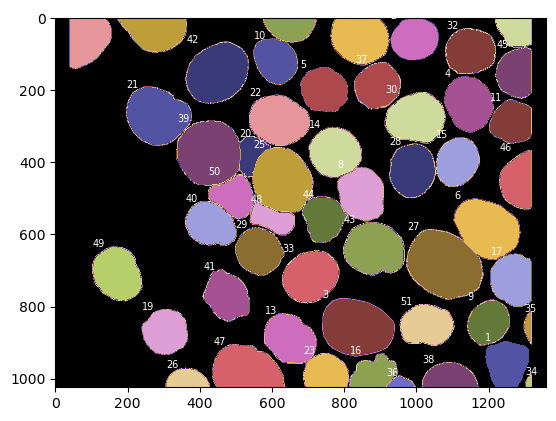

In [127]:

def plot_mask(mask: np.array, axis = None):
    """Plot mask with a different color per object and title."""
    nobjs = len(np.unique(mask))
    if nobjs<3:
        labels, nobjs = measure.label(mask, return_num=True, connectivity=1)
    else:
        labels = mask
    try:
        objs = measure.regionprops(labels)
    except TypeError: # because of TensorMask type
        mask = mask.numpy()
        objs = measure.regionprops(labels)
    
    # create colormap: one color per object
    cmap = cm.get_cmap('tab20b', nobjs)

    # random shuffle to avoid similar colors to close-by objects
    np.random.shuffle(cmap.colors)

    # add black for background
    cmap = ListedColormap(np.insert(cmap.colors, 0, [0, 0, 0, 1], axis=0))

    # plot mask
    if axis is None:
        fig, axis = plt.subplots(1, 1, figsize=(8, 8))
    else: 
        fig = axis.figure
    axis.imshow(labels, cmap=cmap, vmin=0, vmax=nobjs)
    for obj in objs:
        plt.text(obj.bbox[1], obj.bbox[0], obj.label,
                 fontdict=dict(color='white', size=7),
                 bbox=dict(fill=False, linewidth=0)
                 )

    return fig, axis, cmap


def _get_mask(batch_id, dataloader):
    _, mask = _get_dataloader_batch(batch_id, dataloader)
    mask = mask.squeeze().to('cpu')
    return mask

mask = _get_mask(batch_id, test_dl)
# mask = mask.squeeze().to('cpu')
# mask = mask.numpy()

f, x = plt.subplots()
plot_mask(mask.numpy(), x)

In [121]:
from skimage import measure

mask = _get_mask(batch_id, test_dl)
try:
    o = measure.regionprops(mask)
except: 
    mask = mask.numpy()
    o = measure.regionprops(mask)
    

/home/luca/miniconda3/envs/fluocells/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/home/luca/workspace/luca/PycharmProjects/fluocells-BVPAI/fluocells/utils/data.py:519: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(


TypeError: Cannot interpret 'torch.int64' as a data type

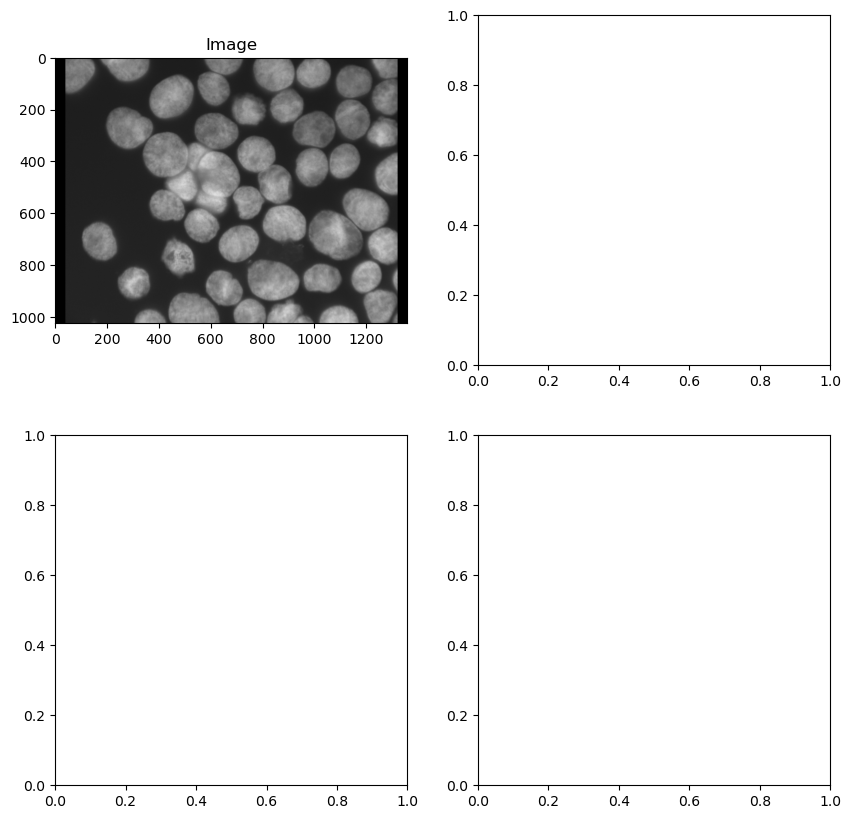

In [123]:
threshold = 0.875
smooth_disk = 10
max_hole = 500
min_size = 200
max_dist = 30
fp = 40
iou_thresh = 0.4
prox_thresh = 40


def _get_mask(batch_id, dataloader):
    _, mask = _get_dataloader_batch(batch_id, dataloader)
    return mask.squeeze().to('cpu')


mask = _get_mask(batch_id, test_dl)
thresh_image = np.squeeze((heatmap_plot.numpy() > threshold).astype('uint8'))
post_proc_mask = post_process(thresh_image, smooth_disk, max_hole, min_size, max_dist, fp)

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()

axes[0].imshow(img)
axes[0].set_title('Image')
# axes[1].imshow(mask, cmap='gray')
plot_mask(mask, axes[1])
axes[1].set_title('Binary mask')
axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title('Raw prediction')
plot_mask(post_proc_mask, axes[3])
axes[3].set_title('Post processed')
plt.show()

# Evaluation

Here we demonstrate the suggested metrics for segmentation and detection tasks, namely **IoU** and **proximity** objects matching.

In the case of **IoU**, this associates true and predicted objects that overlap by more than a given `IOU_THRESH` cutoff. In this way, we test model's ability to precisely reconstruct neurons shape.

Regarding **proximity**, this time we associate objects whose centers are closer than `PROX_THRESH`. The latter criterion is looser, as it only requires the reconstructed object to be sufficiently close to the actual one.
For this reason, this metric can be representative of detection performance in applications where sharp contours are not needed.

In [102]:
# Usage
from skimage import measure
from fluocells.utils.metrics import iou_metrics


IOU_THRESH = 0.4

mask_label = measure.label(mask)

pred_mask_label = measure.label(post_proc_mask)

TP, FP, FN = iou_metrics(mask_label, pred_mask_label, IOU_THRESH)
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

True Positives: 10, False Positives: 5, False Negatives: 5


In [76]:
# Usage
from skimage import measure
from fluocells.utils.metrics import proximity_metrics

PROX_THRESH = 50

mask_label = measure.label(mask)
pred_mask_label = measure.label(post_proc_mask)

TP, FP, FN = proximity_metrics(mask_label, pred_mask_label, PROX_THRESH)
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

True Positives: 37, False Positives: 43, False Negatives: 2


<div class="alert alert-block alert-info">

As expected, the proximity criterion produces better metrics compared to IoU object matching. 
In fact, the model is able to detect the neurons correctly, however it finds hard times trying to reproduce their shape (cf. for instance objects 1 to 10 in the *post processed* mask).
</div>